In [1]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import gc
import os
# Import necessary 4-bit quantization support libraries
import bitsandbytes as bnb
from transformers import BitsAndBytesConfig

# Set device
device = "cuda"

# Load shared tokenizer (only needs to be loaded once)
tokenizer = AutoTokenizer.from_pretrained("unsloth/llama-3-8b")

# Read local txt file, process line by line
def read_text_file(file_path):
    print(f"Reading file: {file_path}")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    print(f"Successfully read {len(lines)} lines of text")
    return lines

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

In [3]:
# Specify file path (replace with your actual file path)
file_path = "./perplexity_check.txt"
lines = read_text_file(file_path)
text = "".join(lines)  # Directly join all lines, preserving original format

# Encode the dataset
encodings = tokenizer(text, return_tensors="pt")

# Define evaluation function
def evaluate_model(model_id):
    print(f"Evaluating model: {model_id}")

    # Create 4-bit quantization configuration
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,                     # Enable 4-bit quantization
        bnb_4bit_quant_type="nf4",             # Use NF4 quantization type (optimized for neural networks)
        bnb_4bit_compute_dtype=torch.bfloat16, # Use bfloat16 for computation
        bnb_4bit_use_double_quant=True,        # Enable double quantization to further save memory
    )

    # Load model using quantization configuration
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="auto",                     # Automatically manage device mapping
        quantization_config=quantization_config # Use quantization config instead of separate parameters
    )

    # Get model configuration
    max_length = min(model.config.max_position_embeddings, 4096)  # Limit maximum length to avoid OOM
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0

    # Calculate loss using sliding window
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100  # Ignore non-target tokens

        # Use torch.no_grad() to reduce memory usage
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    # Calculate perplexity
    ppl = torch.exp(torch.stack(nlls).mean())

    # Clean up memory
    del model
    torch.cuda.empty_cache()
    gc.collect()

    return ppl.item()

Reading file: ./perplexity_check.txt
Successfully read 1180 lines of text


In [4]:
# Evaluate two models in sequence
model_ids = [
    "Benz003/llama3_finetune_rank32",
    "unsloth/llama-3-8b"
]

results = {}
for model_id in model_ids:
    ppl = evaluate_model(model_id)
    results[model_id] = ppl
    print(f"Perplexity of model {model_id}: {ppl:.2f}")

print("\nFinal results comparison:")
for model_id, ppl in results.items():
    print(f"Model: {model_id}, Perplexity: {ppl:.2f}")

Evaluating model: Benz003/llama3_finetune_rank32


config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

 64%|██████▎   | 14/22 [00:07<00:04,  1.90it/s]


Perplexity of model Benz003/llama3_finetune_rank32: 13.90
Evaluating model: unsloth/llama-3-8b


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

 64%|██████▎   | 14/22 [00:06<00:03,  2.07it/s]


Perplexity of model unsloth/llama-3-8b: 13.92

Final results comparison:
Model: Benz003/llama3_finetune_rank32, Perplexity: 13.90
Model: unsloth/llama-3-8b, Perplexity: 13.92


In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# Create 4-bit quantization configuration
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,                     # Enable 4-bit quantization
    bnb_4bit_quant_type="nf4",             # Use NF4 quantization type (optimized for neural networks)
    bnb_4bit_compute_dtype=torch.bfloat16, # Use bfloat16 for computation
    bnb_4bit_use_double_quant=True,        # Enable double quantization to further save memory
)

# Load model using quantization configuration
tokenizer = AutoTokenizer.from_pretrained("Benz003/llama3_finetune_rank32")
model = AutoModelForCausalLM.from_pretrained(
    "Benz003/llama3_finetune_rank32",
    quantization_config=quantization_config,  # Apply 4-bit quantization configuration
    device_map="auto"                         # Automatically handle model allocation on available devices
)

# Define Alpaca style prompt template
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

# Construct input content
inputs = tokenizer(
    [
        alpaca_prompt.format(
            "Translate to Chinese",  # Instruction
            "Translate the following English Transcript into Chinese. So I'm going to ask you to participate in an experiment, which is that when you leave this room, when you go out into the world, today, tomorrow, whenever you feel like it, I'd like you to ask and answer one question of someone who's a stranger. You might meet them on the bus or walking down the street.",
            ""  # Output left empty, waiting for generation
        )
    ],
    return_tensors="pt"
).to("cuda")

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
# Configure generation parameters with additional control options
generation_config = {
    "max_new_tokens": 256,
    "temperature": 0.9,
    "top_p": 0.9,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id  # Prevents issues with tokenizers that don't have a pad token
}

# Generate output
outputs = model.generate(**inputs, **generation_config)

# Decode output text
decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(decoded_output)

# Extract the actual response portion (optional, depends on model output format)
response_marker = "### Response:"
if response_marker in decoded_output:
    actual_response = decoded_output.split(response_marker)[1].strip()
    print("\nActual translation result:")
    print(actual_response)

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Translate to Chinese

### Input:
Translate the following English Transcript into Chinese. So I'm going to ask you to participate in an experiment, which is that when you leave this room, when you go out into the world, today, tomorrow, whenever you feel like it, I'd like you to ask and answer one question of someone who's a stranger. You might meet them on the bus or walking down the street.

### Response:
当你离开这间房间,出去到世界上,今天,明天,你想的时候,我想你去问问一个陌生人,并回答这个问题。你可能会在公交车或行人中遇到他们。


Actual translation result:
当你离开这间房间,出去到世界上,今天,明天,你想的时候,我想你去问问一个陌生人,并回答这个问题。你可能会在公交车或行人中遇到他们。


In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import re
import os
from tqdm import tqdm  # For displaying progress bars

# Create 4-bit quantization configuration
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,                     # Enable 4-bit quantization
    bnb_4bit_quant_type="nf4",             # Use NF4 quantization type (optimized for neural networks)
    bnb_4bit_compute_dtype=torch.bfloat16, # Use bfloat16 for computation
    bnb_4bit_use_double_quant=True,        # Enable double quantization to further save memory
)

print("Loading model, please wait...")

# Load model using quantization configuration
tokenizer = AutoTokenizer.from_pretrained("Benz003/llama3_finetune_rank32") # unsloth/llama-3-8b
model = AutoModelForCausalLM.from_pretrained(
    "Benz003/llama3_finetune_rank32", # unsloth/llama-3-8b
    quantization_config=quantization_config,  # Apply 4-bit quantization configuration
    device_map="auto"                         # Automatically handle model allocation on available devices
)

print("Model loading complete!")

# Define Alpaca style prompt template
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

def translate_transcript_chunk(chunk_text):
    """
    Translate text chunk, preserving timestamp format

    Parameters:
    chunk_text (str): The text chunk to translate

    Returns:
    str: Translated text
    """
    # Construct input content
    instructions = "Translate the following transcript from English to Chinese. Keep all timestamps exactly as they are in the original format. Only translate the text after each timestamp. The response should only contain translated text."

    inputs = tokenizer(
        [
            alpaca_prompt.format(
                instructions,
                chunk_text,
                ""  # Output left empty, waiting for generation
            )
        ],
        return_tensors="pt"
    ).to("cuda")

    # Configure generation parameters
    generation_config = {
        "max_new_tokens": 20,              # Adjusted to accommodate longer text
        "temperature": 0.7,                # Temperature controls creativity
        "top_p": 0.9,                      # Nucleus sampling parameter
        "do_sample": True,                 # Enable sampling
        "pad_token_id": tokenizer.eos_token_id  # Use EOS as padding token
    }

    # Generate output
    outputs = model.generate(**inputs, **generation_config)

    # Decode output text
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract the actual response portion
    response_marker = "### Response:"
    if response_marker in decoded_output:
        # print("\nTranslation: " + decoded_output.split(response_marker)[1].strip())
        return decoded_output.split(response_marker)[1].strip()
    return decoded_output

def process_file(input_file, output_file, chunk_size=10):
    """
    Process input file and save translation results to output file

    Parameters:
    input_file (str): Input file path
    output_file (str): Output file path
    chunk_size (int): Number of lines to process at a time
    """
    # Check if input file exists
    if not os.path.exists(input_file):
        print(f"Error: Input file '{input_file}' not found")
        return

    # Read input file
    with open(input_file, 'r', encoding='utf-8') as f:
        lines = [line.rstrip() for line in f.readlines()]

    # Divide text into chunks
    chunks = []
    for i in range(0, len(lines), chunk_size):
        chunk = lines[i:min(i + chunk_size, len(lines))]
        chunks.append('\n'.join(chunk))

    print(f"File has been divided into {len(chunks)} chunks for translation...")

    # Translate each chunk
    translated_chunks = []
    for i, chunk in enumerate(tqdm(chunks, desc="Translation progress")):
        translated_chunk = translate_transcript_chunk(chunk)
        translated_chunks.append(translated_chunk)

    # Merge results and clean up
    full_translation = '\n'.join(translated_chunks)
    full_translation = re.sub(r'\n\s*\n', '\n\n', full_translation)  # Remove excess empty lines

    # Write results to output file
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(full_translation)

    print(f"Translation complete! Results saved to '{output_file}'")

# Helper function for handling special cases with timestamps
def fix_timestamps(text):
    """
    Fix timestamps that may have been incorrectly processed

    Parameters:
    text (str): Text containing potentially damaged timestamps

    Returns:
    str: Fixed text
    """
    # Match patterns like "number:number" to ensure they aren't translated
    return re.sub(r'(\d+)[：:]\s*(\d+)', r'\1:\2', text)

if __name__ == "__main__":
    # Default file paths
    input_file = "school.txt"
    output_file = "transcript_zh.txt"

    # Prompt user for file paths
    user_input = input(f"Please enter the path of the text file to be translated (default is {input_file}): ")
    if user_input.strip():
        input_file = user_input

    user_output = input(f"Please enter the file path to save the translation results (default is {output_file}): ")
    if user_output.strip():
        output_file = user_output

    # Prompt user for chunk size
    chunk_size_input = input("Please enter the number of lines to process at once (default is 10 lines): ")
    chunk_size = int(chunk_size_input) if chunk_size_input.strip().isdigit() else 10

    # Start processing
    process_file(input_file, output_file, chunk_size)

Loading model, please wait...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model loading complete!
Please enter the path of the text file to be translated (default is school.txt): ./brain.txt
Please enter the file path to save the translation results (default is transcript_zh.txt): finetuned_llama3_zh.txt
Please enter the number of lines to process at once (default is 10 lines): 1
File has been divided into 362 chunks for translation...


Translation progress: 100%|██████████| 362/362 [06:30<00:00,  1.08s/it]

Translation complete! Results saved to 'finetuned_llama3_zh.txt'


In [9]:
!pip install sacrebleu jieba
import re
import pandas as pd
import matplotlib.pyplot as plt
import sacrebleu
import jieba
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 11.7 MB/s eta 0:00:00


In [10]:
def load_transcript(file_path):
    """Load subtitle file and return a dictionary with timecodes as keys"""
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    # Use regular expressions to match timecodes and text
    pattern = r'(\d{2}:\d{2})\s+(.*?)(?=\n\d{2}:\d{2}|\Z)'
    matches = re.findall(pattern, content, re.DOTALL)

    # Create mapping from timecode to text and clean the text
    time_to_text = {}
    for time_code, text in matches:
        # Normalize timecode (handle possible format errors)
        if time_code.endswith(':60'):
            minute, _ = time_code.split(':')
            time_code = f"{minute}:59"

        # Clean text (remove excess spaces and line breaks)
        cleaned_text = re.sub(r'\s+', ' ', text).strip()
        time_to_text[time_code] = cleaned_text

    return time_to_text

In [11]:
def align_transcripts(transcripts_dict):
    """Align multiple subtitle files, ensuring only content with common timecodes is compared"""
    # Find timecodes that are common across all subtitle files
    common_time_codes = set.intersection(*[set(transcript.keys()) for transcript in transcripts_dict.values()])

    # Create dictionary with aligned transcripts
    aligned_transcripts = {}
    for name, transcript in transcripts_dict.items():
        aligned_transcripts[name] = {tc: transcript[tc] for tc in common_time_codes}

    return aligned_transcripts, sorted(list(common_time_codes))

In [12]:
def count_untranslated_segments(text):
    """Count the number of untranslated English segments in the text"""
    # Match segments containing at least 3 consecutive English words
    pattern = r'[a-zA-Z]+\s+[a-zA-Z]+\s+[a-zA-Z]+'
    matches = re.findall(pattern, text)
    return len(matches)

In [13]:
def calculate_bleu(reference_texts, hypothesis_texts):
    """Calculate the overall BLEU score"""
    # Tokenize the Chinese texts
    segmented_refs = []
    for ref in reference_texts:
        segmented_refs.append(' '.join(jieba.cut(ref)))

    segmented_hyps = []
    for hyp in hypothesis_texts:
        segmented_hyps.append(' '.join(jieba.cut(hyp)))

    # Use sacrebleu for scoring
    bleu = sacrebleu.corpus_bleu(
        segmented_hyps,
        [segmented_refs],
        tokenize='none'  # Already tokenized, no need to tokenize again
    )

    return bleu.score

In [14]:
def evaluate_translations(transcript_paths):
   """Main function for evaluating translation quality"""
   # Load all subtitles
   print("Loading translation files...")
   transcripts = {}
   for name, path in transcript_paths.items():
       transcripts[name] = load_transcript(path)
       print(f"  - {name}: Loaded {len(transcripts[name])} segments")

   # Align all subtitles
   print("\nAligning timecodes...")
   aligned_transcripts, common_time_codes = align_transcripts(transcripts)
   print(f"Found {len(common_time_codes)} common timecodes")

   # Prepare results storage
   results = {
       'human_vs_machine': {},
       'english_vs_machine': {},
       'untranslated_segments': {}
   }

   # Extract reference translations and English originals
   human_texts = [aligned_transcripts['human_translation'][tc] for tc in common_time_codes]
   english_texts = [aligned_transcripts['english_original'][tc] for tc in common_time_codes]

   # Calculate BLEU scores and number of untranslated segments
   for name, transcript in aligned_transcripts.items():
       if name not in ['human_translation', 'english_original']:
           # Extract text from the current translation
           machine_texts = [transcript[tc] for tc in common_time_codes]

           # Calculate BLEU score compared to human translation
           results['human_vs_machine'][name] = calculate_bleu(human_texts, machine_texts)

           # Calculate BLEU score compared to English original
           results['english_vs_machine'][name] = calculate_bleu(english_texts, machine_texts)

           # Calculate untranslated segments
           untranslated_count = sum(count_untranslated_segments(text) for text in machine_texts)
           results['untranslated_segments'][name] = untranslated_count / len(machine_texts)

   # Generate detailed segment-by-segment comparison
   segment_comparison = []
   for i, tc in enumerate(common_time_codes):
       entry = {
           'Timecode': tc,
           'English Original': aligned_transcripts['english_original'][tc],
           'Human Translation': aligned_transcripts['human_translation'][tc]
       }

       # Add machine translations
       for name in aligned_transcripts.keys():
           if name not in ['human_translation', 'english_original']:
               entry[name] = aligned_transcripts[name][tc]

       segment_comparison.append(entry)

   return results, pd.DataFrame(segment_comparison)

In [15]:
def visualize_results(results):
    """Visualize evaluation results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Human translation comparison
    axes[0, 0].bar(results['human_vs_machine'].keys(), results['human_vs_machine'].values())
    axes[0, 0].set_title('BLEU Scores Compared to Human Translation')
    axes[0, 0].set_ylabel('BLEU Score')
    axes[0, 0].set_ylim(0, 100)

    # English original comparison
    axes[0, 1].bar(results['english_vs_machine'].keys(), results['english_vs_machine'].values())
    axes[0, 1].set_title('BLEU Scores Compared to English Original')
    axes[0, 1].set_ylabel('BLEU Score')
    axes[0, 1].set_ylim(0, 100)

    # Untranslated segments proportion
    axes[1, 0].bar(results['untranslated_segments'].keys(),
                  [v*100 for v in results['untranslated_segments'].values()])
    axes[1, 0].set_title('Percentage of Untranslated English Segments (%)')
    axes[1, 0].set_ylabel('Percentage')

    # Combined scores (BLEU score minus untranslated penalty)
    combined_scores = {}
    for name in results['human_vs_machine'].keys():
        # Combined score = BLEU score - untranslated penalty
        combined_scores[name] = results['human_vs_machine'][name] - (results['untranslated_segments'][name] * 50)

    axes[1, 1].bar(combined_scores.keys(), combined_scores.values())
    axes[1, 1].set_title('Combined Score (BLEU - Untranslated Penalty)')
    axes[1, 1].set_ylabel('Score')

    plt.tight_layout()
    plt.savefig('translation_evaluation.png', dpi=300)
    plt.show()

    return combined_scores

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...


Loading translation files...
  - english_original: Loaded 362 segments
  - human_translation: Loaded 362 segments
  - finetuned_llama3: Loaded 343 segments
  - llama3: Loaded 340 segments

Aligning timecodes...
Found 321 common timecodes


Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.695 seconds.
DEBUG:jieba:Loading model cost 0.695 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


Detailed segment-by-segment comparison results have been saved to segment_comparison.csv


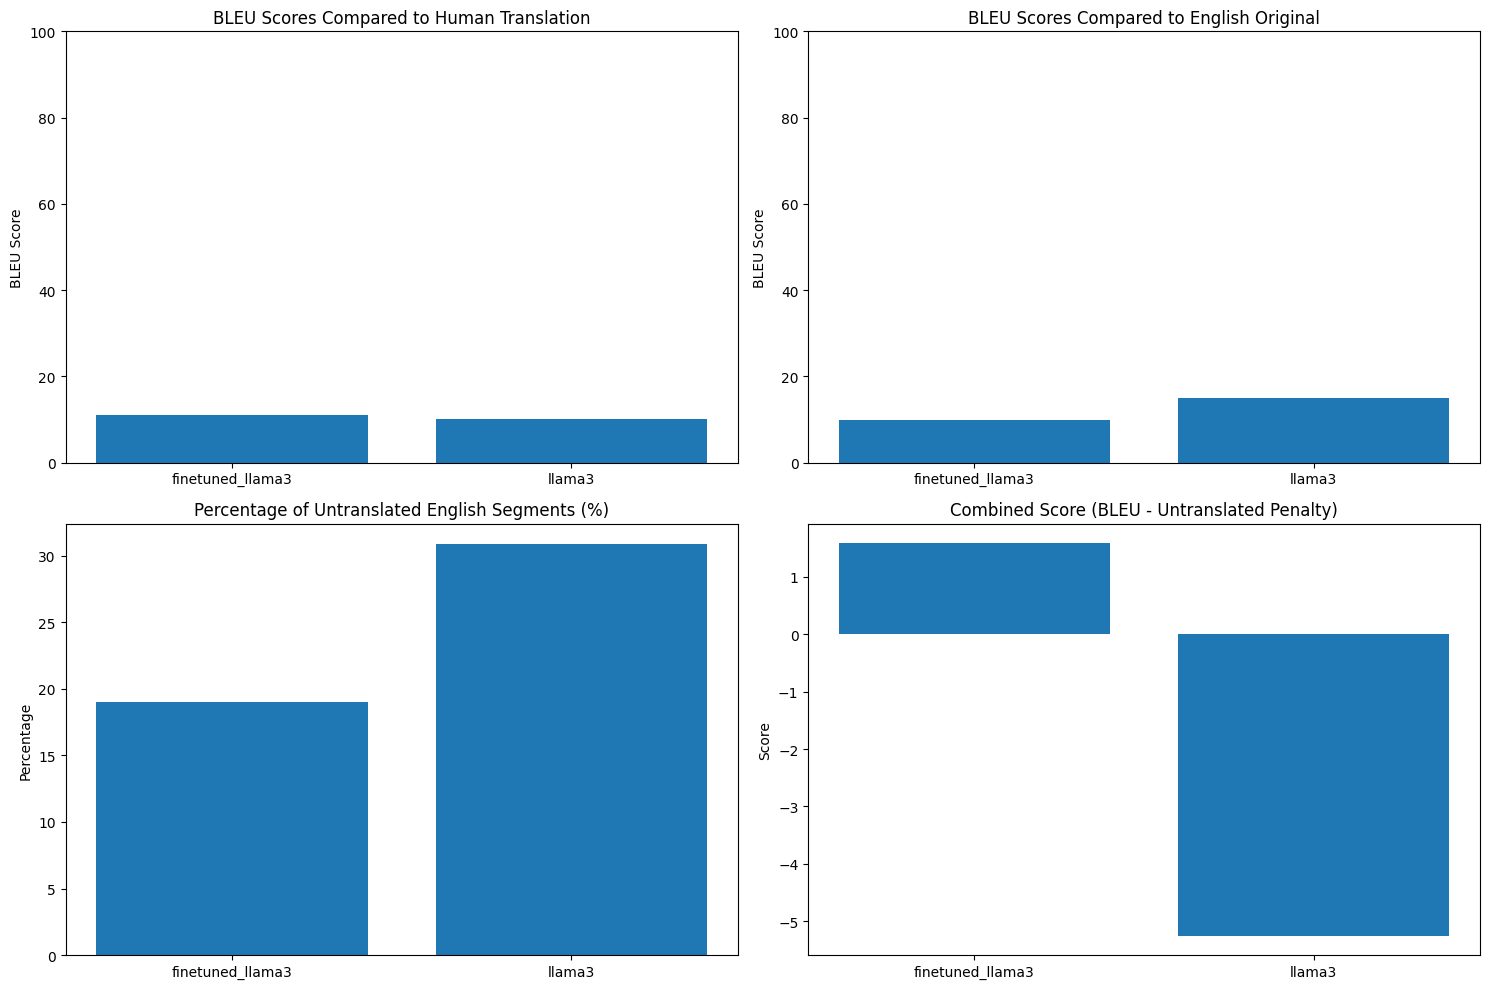


=== Combined Scoring Results ===
finetuned_llama3: 1.58
llama3: -5.25

Based on combined scoring, the best translation is: finetuned_llama3


In [16]:
transcript_paths = {
   "english_original": "Your Brain Hallucinates Your Conscious Reality _ Anil Seth _ TED - EN_updated.txt",
   "human_translation": "Your Brain Hallucinates Your Conscious Reality _ Anil Seth _ TED - CN_newfix.txt",
   "finetuned_llama3": "finetuned_llama3_zh_cleaned.txt",
   "llama3": "llama3_zh_cleaned.txt"
}

# Evaluate translations
results, segment_df = evaluate_translations(transcript_paths)

# Save detailed comparison results
segment_df.to_csv('segment_comparison.csv', index=False, encoding='utf-8-sig')
print("Detailed segment-by-segment comparison results have been saved to segment_comparison.csv")

# Visualize results
combined_scores = visualize_results(results)

# Print combined results
print("\n=== Combined Scoring Results ===")
for name, score in combined_scores.items():
   print(f"{name}: {score:.2f}")

# Determine the best translation
best_translation = max(combined_scores.items(), key=lambda x: x[1])[0]
print(f"\nBased on combined scoring, the best translation is: {best_translation}")